In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

from util.custom_loss.custom_loss import mse_loss, sparsity_loss, dirichlet_loss
from util.ImageFolderWithPaths import ImageFolderWithPaths
from util.random_patient import random_split

In [2]:
print(torch.cuda.device_count())
torch.cuda.empty_cache()
torch.cuda.mem_get_info()

1


(16790978560, 17059545088)

In [3]:
BATCH_SIZE = 4

# setting the correct device to train on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

MAIN_PATH = '/home/u6/njcrutchfield/torch/NN/pill_data/pillQC-main/images' # images are 225 x 225 x 3
# PATH1 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/A'
# PATH2 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/S'

tensor_transform = transforms.ToTensor()
horizontal_flip = transforms.RandomHorizontalFlip(p=1)

# Dataset of both normal and horizontal flipped images
dataset = datasets.ImageFolder(MAIN_PATH, transform = tensor_transform) + datasets.ImageFolder(MAIN_PATH, transform=transforms.Compose([
                                                                                                                     tensor_transform,
                                                                                                                     horizontal_flip
                                                                                                                   ]))


In [4]:
SPLIT = [528, 66, 66]
train_set, _, _ = torch.utils.data.random_split(dataset,
                                                SPLIT,# 80%, 10%, 10%
                                                generator=torch.Generator(device=device))

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [35]:
class Encoder(nn.Module):
    def __init__(self, in_channel=3, out_channel=3500, activation=nn.GELU()):
        super().__init__()
        # The input size is 3*250*250
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.encoder = nn.Sequential(
                                nn.Conv2d(in_channels=in_channel,out_channels=16,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(16), activation,
                                nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(32), activation,
                                nn.Conv2d(in_channels=32,out_channels=32,kernel_size=2,stride=2,padding=1,bias=False),
                                nn.BatchNorm2d(32), activation,
                                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=2,padding=1,bias=False),
                                nn.BatchNorm2d(64), activation,
                                nn.Conv2d(in_channels=64,out_channels=64,kernel_size=2,stride=2,padding=0,bias=False),
                                nn.BatchNorm2d(64), activation,
                                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(128), activation,
                                nn.Conv2d(in_channels=128,out_channels=128,kernel_size=2,stride=2,padding=0,bias=False),
                                nn.BatchNorm2d(128), activation,
                                nn.Conv2d(in_channels=128,out_channels=320,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(320), activation,
                                nn.Conv2d(in_channels=320,out_channels=240,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(240), activation,
                                nn.Conv2d(in_channels=240,out_channels=150,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(150), activation,
                                nn.Conv2d(in_channels=150,out_channels=80,kernel_size=3,stride=2,padding=1,bias=False),
                                nn.BatchNorm2d(80), activation,
                                nn.Conv2d(in_channels=80,out_channels=40,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(40), activation,
                                nn.Conv2d(in_channels=40,out_channels=15,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(15), activation,
                                nn.Flatten(),
                                nn.Linear(in_features=16*16*15, out_features=out_channel),
                                nn.Softmax(dim=1))
        
    def forward(self, x):
        # x = x.view(-1, self.in_channel, 250, 250)
        prob = self.encoder(x)
        return prob


class Decoder(nn.Module):
    def __init__(self, in_channel=3, out_channel=1600, activation=nn.GELU()):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel

        self.mlp = nn.Sequential(nn.Linear(in_features=out_channel, out_features=16*16*15, bias=False),
                                 nn.BatchNorm1d(16*16*15),activation)
        self.decoder = nn.Sequential(nn.ConvTranspose2d(in_channels=15,out_channels=40,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(40), activation,
                                     nn.ConvTranspose2d(in_channels=40,out_channels=80,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(80), activation,
                                nn.ConvTranspose2d(in_channels=80,out_channels=150,kernel_size=3,stride=2,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(150), activation,
                                nn.ConvTranspose2d(in_channels=150,out_channels=240,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(240), activation,
                                nn.ConvTranspose2d(in_channels=240,out_channels=320,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(320), activation,
                                nn.ConvTranspose2d(in_channels=320,out_channels=128,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(128), activation,
                                nn.ConvTranspose2d(in_channels=128,out_channels=128,kernel_size=3,stride=2,padding=1,output_padding=1,bias=False),
                                nn.BatchNorm2d(128), activation,
                                nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(64), activation,
                                nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=3,stride=2,padding=1,output_padding=1,bias=False),
                                nn.BatchNorm2d(64), activation,
                                nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(32), activation,
                                nn.ConvTranspose2d(in_channels=32,out_channels=32,kernel_size=3,stride=2,padding=1,output_padding=1,bias=False),
                                nn.BatchNorm2d(32), activation,
                                nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(16), activation,
                                nn.ConvTranspose2d(in_channels=16, out_channels=in_channel, kernel_size=(3,3), stride=1, padding=0, output_padding=0),
                                nn.Sigmoid())
    
    def forward(self, x):
        # x = x.view(-1, self.out_channel)
        temp = self.mlp(x)
        temp = temp.view(-1,15,16,16)
        output = self.decoder(temp)
        return output

In [36]:
enc_out = 3500
encoder = Encoder(out_channel = enc_out)

rand_mat_dim = 1600
decoder = Decoder(out_channel = rand_mat_dim)

In [37]:
rand_mat = torch.randn(rand_mat_dim, enc_out, requires_grad=False, device='cuda' if torch.cuda.is_available() else 'cpu')
rand_mat = rand_mat.div(torch.norm(rand_mat, dim = 0))

In [38]:
for col in range(len(rand_mat[0])):
    s = 0
    for row in range(len(rand_mat)):
        s += rand_mat[row][col] ** 2
    s = s ** 0.5
    if not (s > 0.99999 and s < 1.000001):
        print(s)

KeyboardInterrupt: 

In [39]:
rand_mat.size()

torch.Size([1600, 3500])

In [40]:
with open('progress.txt', 'w') as file:
    file.write(f"{Encoder=}\n\n{Decoder=}\n\nTraining:\n")

In [41]:
EPOCHS = 100
loss_weights = [1, 0.001, 0] # [1,0,0]
early_stop_depth = 10
verbose = 1

LR = 0.00005 # [0.00005]
WEIGHT_DECAY = 0.01 # [0.01]

In [42]:
class AE(torch.nn.Module):
    def __init__(self, encoder, decoder, rand_mat):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.rand_mat = rand_mat
        
    def forward(self, x):
        enc = encoder(x)
        all_dps = []
        for batch in enc:
            all_dps.append(torch.mv(self.rand_mat, batch))
        Dp = torch.stack(all_dps)
        
        p_vec = F.softmax(Dp, dim = 1)
        
        dec = decoder(p_vec)
        return dec

In [43]:
ae = AE(encoder, decoder, rand_mat).to(device)

In [44]:
optimizer = torch.optim.Adam(ae.parameters(), lr = LR, weight_decay = WEIGHT_DECAY)

In [45]:
torch.autograd.set_detect_anomaly(True)

encoder.to(device)
decoder.to(device)

for epoch in range(EPOCHS):
    for img, _ in train_loader:
        encoder.train()
        decoder.train()
        
        img = img.to(device)
        
        dec = ae(img)
        
        loss =  (loss_weights[0] * mse_loss(dec, img) +
                loss_weights[1] * sparsity_loss(p_vec) +
                loss_weights[2] * dirichlet_loss(p_vec))
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        text = f'\nEpoch: {epoch + 1} | Loss: {loss.item():.4f}'
        print(text, end='\n'*2)
        with open('progress.txt', 'a') as file:
            file.write(f"{text}\n\n")
        
        


RuntimeError: mat1 and mat2 shapes cannot be multiplied (4x2940 and 3840x3500)

In [14]:
#torch.save(AE.state_dict(), f'./models/ae_model_gs.pth')
if len(LR) == 1 and len(WEIGHT_DECAY) == 1: # dont save during grid search, should already be saved
    torch.save(AE.rand_mat, f'./models/ae_model_rand_mat.pth')
    torch.save(AE.state_dict(), f'./models/ae_model_gs.pth')

    with open('progress.txt', 'a') as file:
        file.write(f"Saved\n\n")
    print("done")

done


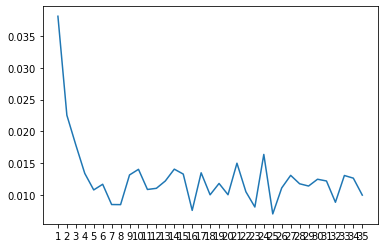

In [15]:
ep = [x+1 for x in range(len(loss_arr))]
plt.plot(ep, loss_arr)
plt.xticks(ep)
plt.show()

In [16]:
print(torch.cuda.mem_get_info())
torch.cuda.empty_cache()

(16056975360, 17059545088)


In [17]:
torch.set_default_device('cuda')

MAIN_PATH = '/home/u6/njcrutchfield/torch/NN/pill_data/pillQC-main/images' # images are 225 x 225 x 3
# PATH1 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/A'
# PATH2 = '/groups/francescavitali/eb2/NewsubSubImages4/H&E/S'

tensor_transform = transforms.ToTensor()
horizontal_flip = transforms.RandomHorizontalFlip(p=1)


# Dataset of both normal and horizontal flipped images
dataset = datasets.ImageFolder(MAIN_PATH, transform = tensor_transform) + datasets.ImageFolder(MAIN_PATH, transform=transforms.Compose([
                                                                                                                      tensor_transform,
                                                                                                                      horizontal_flip
                                                                                                                    ]))
SPLIT = [528, 66, 66]
_, val_set, _ = torch.utils.data.random_split(dataset,
                                                SPLIT,# 80%, 10%, 10%
                                                generator=torch.Generator(device=device))

val_loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = 1,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = AE_CNN(encoded_dim=encoded_dim, rand_mat_dim=rand_mat_dim, rand_mat=False).to(device)
model.load_state_dict(torch.load('./models/ae_model_gs.pth'))
model.rand_mat = torch.load('./models/ae_model_rand_mat.pth')

# setting the encoder and decoder for visualization
encoder = model.encoder
decoder = model.decoder
rand_mat = model.rand_mat

In [19]:
# input and output arrays
auto_encoder_output = []
encoded_imgs_arr = []
decoded_imgs_arr = []


mse_running_total = 0
count = 0

torch.set_default_device('cuda')

for (inp, _) in val_loader:
    model.eval()
    with torch.no_grad():
        inp = inp.to(device)
        oup = model(inp)
        encoded_imgs = torch.mv(rand_mat, model.softmax(encoder(inp))[0])
        encoded_imgs_arr.append(encoded_imgs)
        
#         decoded_imgs = decoder(encoded_imgs)
        mse_running_total += np.square(inp.cpu().numpy() - oup.cpu().numpy()).mean()

        
        
        # decoded_imgs_arr.append((inp, decoded_imgs))
        
        if count % 1 == 0:
            auto_encoder_output.append((inp, model(inp)))
        count += 1



In [20]:
mse_running_total/len(val_loader)

0.01152589292905759

In [21]:
import matplotlib.pyplot as plt

In [22]:
x = torch.nn.functional.softmax(encoded_imgs_arr[0])
y = torch.nn.functional.softmax(encoded_imgs_arr[10])

/home/u6/njcrutchfield/.local/lib/python3.8/site-packages/torch/utils/_device.py:78: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return func(*args, **kwargs)


(array([1., 2., 0., 0., 1., 7., 1., 0., 0., 2., 1., 0., 0., 0., 0., 1.]),
 array([0.03886181, 0.04266359, 0.04646537, 0.05026715, 0.05406893,
        0.05787072, 0.0616725 , 0.06547428, 0.06927606, 0.07307784,
        0.07687962, 0.08068141, 0.08448318, 0.08828497, 0.09208675,
        0.09588853, 0.09969031], dtype=float32),
 <BarContainer object of 16 artists>)

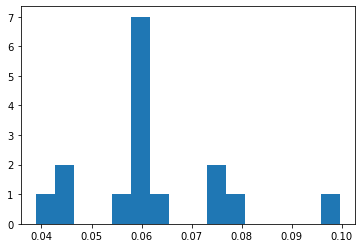

In [23]:
plt.hist(x.cpu().numpy(), bins=len(encoded_imgs_arr[0]))

(array([1., 2., 0., 0., 1., 7., 1., 0., 0., 2., 1., 0., 0., 0., 0., 1.]),
 array([0.03886814, 0.0426688 , 0.04646946, 0.05027013, 0.05407079,
        0.05787145, 0.06167211, 0.06547277, 0.06927343, 0.07307409,
        0.07687476, 0.08067542, 0.08447608, 0.08827674, 0.0920774 ,
        0.09587806, 0.09967873], dtype=float32),
 <BarContainer object of 16 artists>)

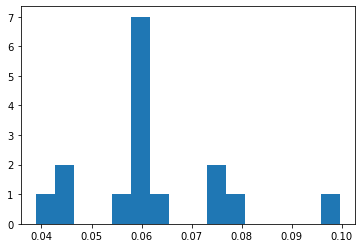

In [24]:
plt.hist(y.cpu().numpy(), bins = len(encoded_imgs_arr[10]))

In [25]:
import random
mse_running_total = 0
arr = []
for i in range(len(encoded_imgs_arr)):
    num = np.square(encoded_imgs_arr[i].cpu().numpy() - encoded_imgs_arr[random.randint(0,len(encoded_imgs_arr)-1)].cpu().numpy()).mean()
    arr.append(num)
    mse_running_total += num
print(f'{mse_running_total=}')

mse_running_total=3.8939787915650463e-05


In [26]:
mse_running_total = 0
for (img, _) in val_loader:
    model.eval()
    with torch.no_grad():

        inp = img.to(device)
        decoded = model(inp)
        mse_running_total += np.square(inp.cpu().numpy() - decoded.cpu().numpy()).mean()
        break

In [27]:
print(inp.size())

torch.Size([1, 3, 225, 225])


torch.Size([3, 225, 225])
0.006854638457298279


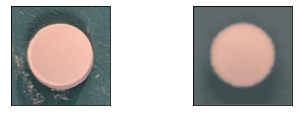

In [28]:
cols = 2
amt = 2
ax = plt.subplot(cols, amt, 1)
img = inp.squeeze()
img = img.detach().cpu().numpy()
plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(cols,amt, 2)
recon = decoded.squeeze()
print(recon.shape)
recon = recon.detach().cpu().numpy()
plt.imshow(np.transpose(recon, (1,2,0)))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

print(mse_running_total)

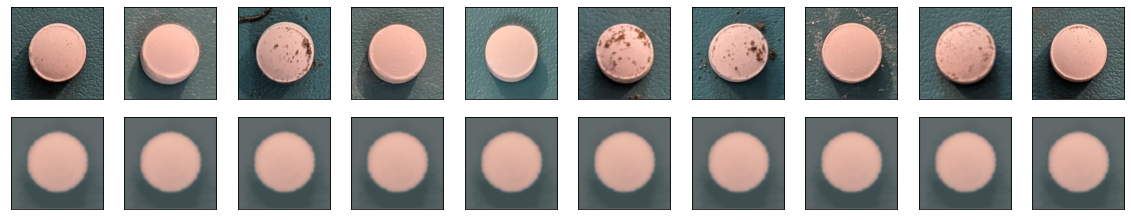

In [29]:
# Validation Set Images
amt = 10
cols = 10
plt.figure(figsize=(20,20))


for k in range(amt):
    
    # input image
    ax = plt.subplot(cols, amt, k+1)
    img = auto_encoder_output[k][0].squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # recon image
    ax = plt.subplot(cols,amt, k+1+amt)
    recon = auto_encoder_output[k+10][1].squeeze()
    recon = recon.detach().cpu().numpy()
    plt.imshow(np.transpose(recon, (1,2,0)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

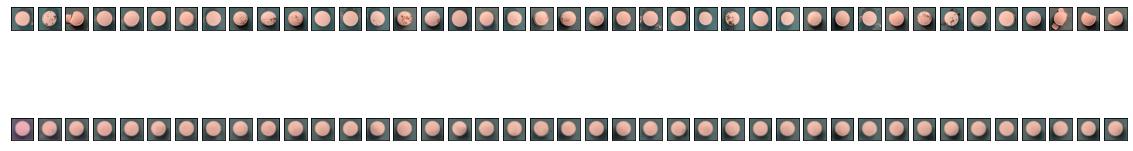

In [33]:
# Training between epochs
amt = len(outputs)
cols = 10
plt.figure(figsize=(20,20))


for k in range(amt):
    
    # input image
    ax = plt.subplot(cols, amt, k+1)
    img = outputs[k][0][0].squeeze()
    img = img.detach().cpu().numpy()
    plt.imshow(np.transpose(img, (1,2,0))) # changes to rgb
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # recon image
    ax = plt.subplot(cols,amt, k+1+amt)
    recon = outputs[k][1][0].squeeze()
    recon = recon.detach().cpu().numpy()
    plt.imshow(np.transpose(recon, (1,2,0)))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [41]:
for i in range(len(auto_encoder_output)-1):
    recon1, recon2 = auto_encoder_output[i][1], auto_encoder_output[i+1][1]
    print(torch.sum(recon1 - recon2))

tensor(-0.2489, device='cuda:0')
tensor(0.8756, device='cuda:0')
tensor(-0.2626, device='cuda:0')
tensor(-5.6138, device='cuda:0')
tensor(7.4324, device='cuda:0')
tensor(-0.6683, device='cuda:0')
tensor(0.6451, device='cuda:0')
tensor(-0.6834, device='cuda:0')
tensor(-0.7923, device='cuda:0')
tensor(0.8338, device='cuda:0')
tensor(-0.3775, device='cuda:0')
tensor(2.8386, device='cuda:0')
tensor(-3.4112, device='cuda:0')
tensor(-0.0397, device='cuda:0')
tensor(0.0844, device='cuda:0')
tensor(1.0365, device='cuda:0')
tensor(-1.3299, device='cuda:0')
tensor(2.5454, device='cuda:0')
tensor(0.4376, device='cuda:0')
tensor(-3.1280, device='cuda:0')
tensor(2.2245, device='cuda:0')
tensor(-0.7780, device='cuda:0')
tensor(-0.1076, device='cuda:0')
tensor(1.4628, device='cuda:0')
tensor(-0.2637, device='cuda:0')
tensor(-3.4468, device='cuda:0')
tensor(1.7268, device='cuda:0')
tensor(0.4359, device='cuda:0')
tensor(-9.1597, device='cuda:0')
tensor(9.9955, device='cuda:0')
tensor(0.4666, device='c

tensor(0.5912, device='cuda:0')
tensor(0.3995, device='cuda:0')
tensor(0.9987, device='cuda:0')
tensor(0.7170, device='cuda:0')
tensor(-2.7908, device='cuda:0')
tensor(1.1652, device='cuda:0')
tensor(-1.4437, device='cuda:0')
tensor(1.6517, device='cuda:0')
tensor(-2.3438, device='cuda:0')
tensor(0.5996, device='cuda:0')
tensor(0.7186, device='cuda:0')
tensor(-1.4384, device='cuda:0')
tensor(1.9357, device='cuda:0')
tensor(0.7747, device='cuda:0')
tensor(-1.4614, device='cuda:0')
tensor(-9.0175, device='cuda:0')
tensor(9.5497, device='cuda:0')
tensor(-0.3816, device='cuda:0')
tensor(1.6249, device='cuda:0')
tensor(0.6597, device='cuda:0')
tensor(-2.6497, device='cuda:0')
tensor(1.6192, device='cuda:0')
tensor(-1.0848, device='cuda:0')
tensor(-0.4096, device='cuda:0')
tensor(0.7300, device='cuda:0')
tensor(0.1893, device='cuda:0')
tensor(-1.9512, device='cuda:0')
tensor(-8.0478, device='cuda:0')
tensor(3.8169, device='cuda:0')
tensor(6.0482, device='cuda:0')
tensor(0.4040, device='cuda: